In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

import os
import requests
from io import BytesIO
from PIL import Image
import numpy as np

import os
import random
import shutil
import matplotlib.pyplot as plt

import cv2

import sys
sys.path.append('.')  
from onedrive_dncnn import authenticate_onedrive, train_dncnn_with_onedrive, test_dncnn_model
from dotenv import load_dotenv

In [ ]:

client = authenticate_onedrive(interactive=True)

load_dotenv()
folder_id = os.getenv('FOLDER_ID')
if not folder_id:
    raise ValueError("FOLDER_ID not set in environment variables")


In [ ]:
def split_images(image_folder, train_ratio=0.8, test_ratio=0.2,seed=42):
    """Splits images into train and test sets."""

    if not os.path.exists(image_folder):
        print(f"Error: Image folder '{image_folder}' not found.")
        return

    images = [img for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(images)
    if num_images == 0:
        print(f"Error: No images found in '{image_folder}'.")
        return
    random.seed(seed)
    random.shuffle(images)  # Shuffle images randomly

    # Calculate split indices
    train_split = int(num_images * train_ratio)
    test_split = int(num_images * (train_ratio + test_ratio))

    # Create train and test directories
    train_dir = os.path.join(image_folder, "train")
    test_dir = os.path.join(image_folder, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Move images to respective directories
    for i, image in enumerate(images):
        source_path = os.path.join(image_folder, image)
        if i < train_split:
            destination_path = os.path.join(train_dir, image)
        elif i < test_split:
            destination_path = os.path.join(test_dir, image)
        else:
            continue

        shutil.move(source_path, destination_path)

    print(f"Images split into train ({train_split} images) and test ({test_split-train_split} images) sets.")


In [ ]:
def prepare_dataset(folder_path, noise_std=0.1):
    """
    Prepara o dataset para treinamento adicionando ruído às imagens.
    """
    def load_and_preprocess_image(path):
        # Carregar e preprocessar imagem
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.cast(img, tf.float32) / 255.0  # Normalizar para [0,1]

        # Adicionar ruído gaussiano
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_std)
        noisy_img = img + noise

        # Clipar valores para manter entre [0,1]
        noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0)

        return noisy_img, img

    # Listar caminhos de todas as imagens na pasta
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.png')]

    # Criar dataset
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(4)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
class DnCNN(Model):
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D

        # Convolution layers
        self.conv_layers = []
        self.conv_layers.append(layers.Conv2D(C, kernel_size=3, padding='same', activation=None, input_shape=(None, None, 3)))

        for _ in range(D):
            self.conv_layers.append(layers.Conv2D(C, kernel_size=3, padding='same', activation=None))

        self.conv_layers.append(layers.Conv2D(3, kernel_size=3, padding='same', activation=None))

        # Batch normalization layers
        self.bn_layers = [layers.BatchNormalization() for _ in range(D)]

    def call(self, x, training=False):
        h = tf.nn.relu(self.conv_layers[0](x))
        for i in range(self.D):
            h = tf.nn.relu(self.bn_layers[i](self.conv_layers[i+1](h), training=training))
        y = self.conv_layers[self.D+1](h) + x
        return y



In [ ]:
image_folder = "images"
split_images(image_folder)

Error: No images found in 'images'.


In [ ]:
train_dataset = prepare_dataset('images/train/', noise_std=0.1)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>

In [ ]:
def train_model(model, train_dataset, epochs=200, learning_rate=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    model.compile(optimizer=optimizer, loss=loss_fn)
    model.fit(train_dataset, epochs=epochs)


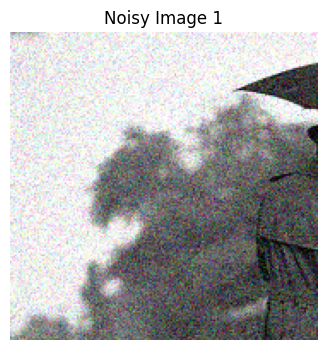

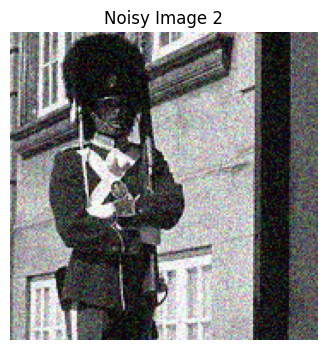

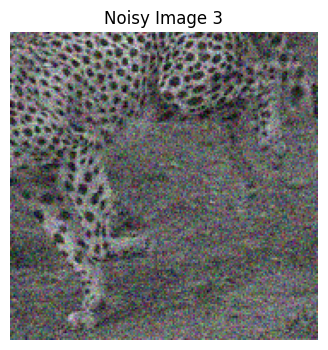

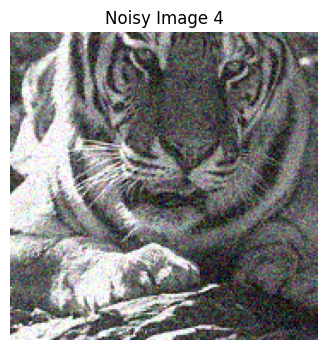

In [ ]:
for noisy_images, noise in train_dataset.take(1):
    for i in range(min(5, noisy_images.shape[0])):
        noisy_image = noisy_images[i].numpy()
        plt.figure(figsize=(4, 4))
        plt.imshow(noisy_image)
        plt.axis('off')
        plt.title(f"Noisy Image {i + 1}")
        plt.show()

In [ ]:
model = DnCNN(D=8)
train_model(model, train_dataset, epochs=200)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - loss: 0.2026
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0103
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0096
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0081
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0066
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0051
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0042
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0036
Epoch 9/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0032
Epoch 10/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0029
Epoch 11/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0027
Epoch 12/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0026
Epoch 13/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0024
Epoch 14/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0023
Epoch 15/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/

In [ ]:
def test_network(model, image_path, noise_std=0.1):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)
    # Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_std)
    noisy_img = img + noise
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0)  # Keep values in [0, 1]

    # Predict noise using the model
    denoised_img = model(noisy_img, training=False)

    # Denoise the image by subtracting the predicted noise
    denoised_img = tf.clip_by_value(denoised_img, 0.0, 1.0)

    # Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(2, 3, 1)
    plt.imshow(tf.squeeze(img).numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(tf.squeeze(noisy_img).numpy())
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(tf.squeeze(denoised_img).numpy())
    plt.title("Denoised Image")
    plt.axis("off")

    plt.show()
    return (img, noisy_img, denoised_img)




In [ ]:
def apply_median_filter(result, kernel_size=3):
    # Convert TensorFlow tensor to numpy array
    img = tf.squeeze(result[0]).numpy()
    noisy_img = tf.squeeze(result[1]).numpy()


    # Apply median filter
    denoised_img = np.zeros_like(noisy_img)
    for i in range(3):  # Apply filter to each channel independently
        denoised_img[:, :, i] = cv2.medianBlur(noisy_img[:, :, i], kernel_size)
    plt.figure(figsize=(15, 5))

    plt.subplot(2, 3, 4)
    plt.imshow(tf.squeeze(img).numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(tf.squeeze(noisy_img).numpy())
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(tf.squeeze(denoised_img).numpy())
    plt.title("Denoised Image")
    plt.axis("off")

    plt.show()



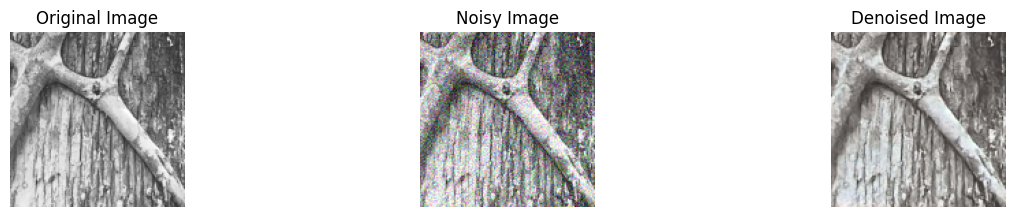

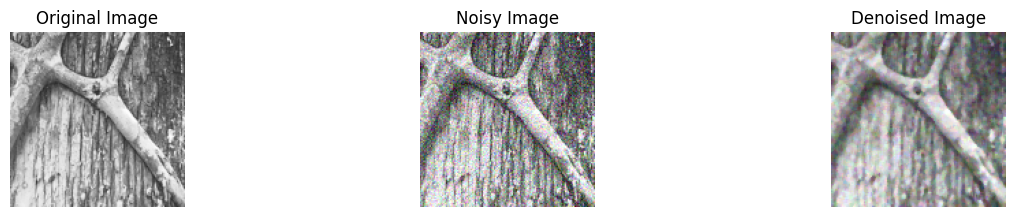

In [ ]:
# Test the network on a sample image
result = test_network(model, "images/test/image_138.png", noise_std=0.1)
median = apply_median_filter(result)

In [ ]:
model.save('/content/weights.keras')